In [0]:
import keras
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import os
from keras.layers import Flatten, Dense, Concatenate
from keras.optimizers import SGD
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tensorflow.keras import regularizers
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import roc_auc_score

In [0]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
# classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
         
#one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:
y_train.shape

(50000, 10)


How to display multiple images in one figure correctly?

https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

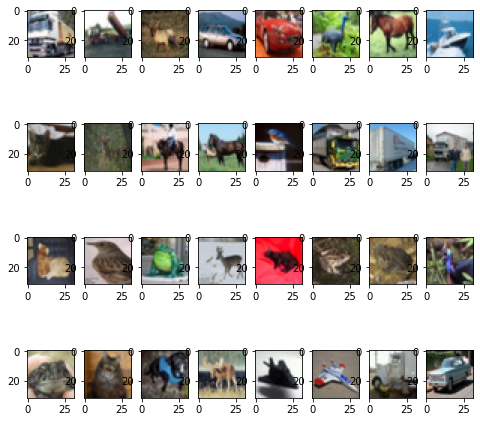

In [0]:
# visualize some (4*8) of the samples in cifar10 train set

fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i])
plt.show()

In [0]:
#input layer
input_img = Input(shape = (32, 32, 3))

In [0]:
#architecture 1

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_1)
tower_1 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_1)
tower_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(tower_1)
tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_1)

output = Flatten()(tower_1)
out    = Dense(10, activation='softmax')(output)

model1 = Model(inputs = input_img, outputs = out)
print(model1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        4160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4160

In [0]:
#architecture 2

out_l = Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
out_l = Conv2D(128, (3,3), padding='same', activation='relu')(out_l)
out_l = Conv2D(256, (1,1), padding='same', activation='relu')(out_l)

#inception module with 3 paths
#first path
path_1 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_1 = Conv2D(64, (3,3), padding='same', activation='relu')(path_1)

#second path
path_2 = Conv2D(64, (1,1), padding='same', activation='relu')(out_l)
path_2 = Conv2D(64, (5,5), padding='same', activation='relu')(path_2)

#third path
path_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(out_l)
path_3 = Conv2D(64, (1,1), padding='same', activation='relu')(path_3)

#concatenate the three paths
out_l = Concatenate()([path_1,path_2,path_3])

output2 = Flatten()(out_l)
out2    = Dense(10, activation='softmax')(output2)

model2 = Model(inputs = input_img, outputs = out2)
print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 128)  73856       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 256)  33024       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [0]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision])
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 51s 1ms/step - loss: 1.5811 - accuracy: 0.4346 - auc: 0.7735 - val_loss: 1.2779 - val_accuracy: 0.5481 - val_auc: 0.8564
Epoch 2/25
50000/50000 [==============================] - 45s 902us/step - loss: 1.0587 - accuracy: 0.6307 - auc: 0.8832 - val_loss: 0.9825 - val_accuracy: 0.6489 - val_auc: 0.9019
Epoch 3/25
50000/50000 [==============================] - 46s 910us/step - loss: 0.8339 - accuracy: 0.7107 - auc: 0.9146 - val_loss: 0.8974 - val_accuracy: 0.6926 - val_auc: 0.9243
Epoch 4/25
50000/50000 [==============================] - 45s 902us/step - loss: 0.6867 - accuracy: 0.7637 - auc: 0.9320 - val_loss: 0.9219 - val_accuracy: 0.6895 - val_auc: 0.9379
Epoch 5/25
50000/50000 [==============================] - 45s 900us/step - loss: 0.5598 - accuracy: 0.8065 - auc: 0.9433 - val_loss: 0.9075 - val_accuracy: 0.7002 - val_auc: 0.9475
Epoch 6/25
40480/50000 [=======================

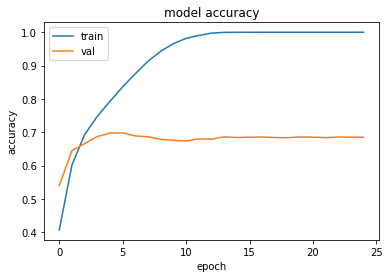

In [0]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 28s 561us/step - loss: 1.6992 - accuracy: 0.3901 - val_loss: 1.4101 - val_accuracy: 0.4892
Epoch 2/25
50000/50000 [==============================] - 28s 559us/step - loss: 1.1781 - accuracy: 0.5827 - val_loss: 1.0538 - val_accuracy: 0.6260
Epoch 3/25
50000/50000 [==============================] - 28s 557us/step - loss: 0.9229 - accuracy: 0.6776 - val_loss: 0.9726 - val_accuracy: 0.6618
Epoch 4/25
50000/50000 [==============================] - 28s 552us/step - loss: 0.7473 - accuracy: 0.7413 - val_loss: 0.9639 - val_accuracy: 0.6641
Epoch 5/25
50000/50000 [==============================] - 28s 555us/step - loss: 0.5959 - accuracy: 0.7962 - val_loss: 0.9819 - val_accuracy: 0.6753
Epoch 6/25
50000/50000 [==============================] - 28s 553us/step - loss: 0.4498 - accuracy: 0.8463 - val_loss: 1.1042 - val_accuracy: 0.6632
Epoch 7/25
50000/50000 [==============================] 

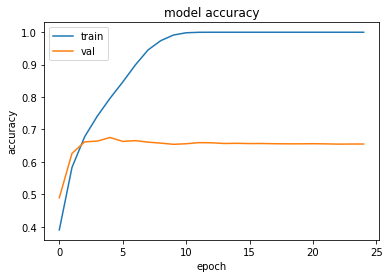

In [0]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pt = PrettyTable()

#n-parameters = number of parameters
#n-layers = number of layers
#overfit: yes means happend, no means not happened

pt.field_names =  ["model", "Accuracy", "runtime" , "overfit" , "n-parameters", "n-layers"]
pt.add_row(["model1"," 68.23%", "lower", "yes", "803,338", "6"])

pt.add_row(["model2","67.82%", "higher", "yes", "2,263,498", "10"])


print(pt)

+--------+----------+---------+---------+--------------+----------+
| model  | Accuracy | runtime | overfit | n-parameters | n-layers |
+--------+----------+---------+---------+--------------+----------+
| model1 |  68.23%  |  lower  |   yes   |   803,338    |    6     |
| model2 |  67.82%  |  higher |   yes   |  2,263,498   |    10    |
+--------+----------+---------+---------+--------------+----------+


Analyse:
- The accuracy of both models is between 65-70% , therfore, not much difference between accuracies.
- Both of the models have been overfitted because of not using methods to avoide overfitting (Although shuffle is true by defualt in model.fit() of Keras and the input data is also shuffled as it is standard data)
- The runtime for the second model is higher than the first model. I think the reason is that the second model has more layers and trainable parameters. Therefore, the computation needs more time to be done.
- The precision and recall for model1 is closer compared to the precision and recall of the model 2. Which means model one is more accurate. (They have been visualized in the "avoid overfitting" notebook )
